# Evaluating a `SINDy` model

There's several broad ways to evaluate pysindy models:
* The functional form, or coefficient evaluation
* The instantaneous derivative prediction
* The simulation forwards in time

Each of these methods may be the best for a given use case,
but each also have unique challenges.
This notebook will take you through different ways you can  evaluate a pysindy model.
It will illustrate the use cases and the drawbacks of each.


Let's take a look at some models.  Some will be good, some will be bad

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

if __name__ != "testing":
    from example_data import get_models
else:
    from mock_data import get_models

from utils import compare_coefficient_plots

In [2]:
t, x, good_model, ok_model, bad_model = get_models()

Our data is the Lorenz system, and each model is trained on progressively less data:

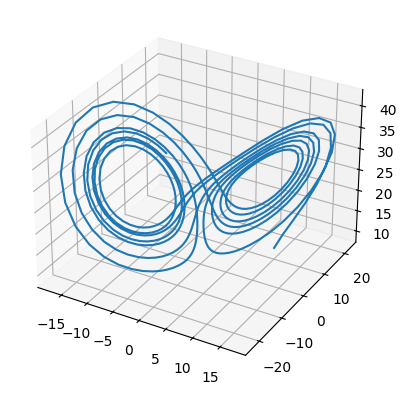

In [3]:
ax = plt.figure().add_subplot(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])

## Coefficient evaluation

The most straightforwards way to evaluate a model is by seeing how well it compares
to the true equations.  The model coefficients are stored in `model.optimizer.coef_`

In [4]:
print("Good:\n")
good_model.print()
print("\nSo-so:")
ok_model.print()
print("\nBad:")
bad_model.print()

Good:

(x)' = -9.914 x + 9.912 y
(y)' = 27.052 x + -0.816 y + -0.972 x z
(z)' = -2.635 z + 0.988 x y

So-so:
(x)' = 0.246 1 + -8.717 x + 8.715 y
(y)' = 1.240 1 + 20.299 x + 0.386 y + -0.774 x z
(z)' = -19.230 1 + 1.803 z + 1.401 x^2 + -0.638 x y + 0.415 y^2 + -0.167 z^2

Bad:
(x)' = -40.935 1 + -9.153 x + 7.479 y + 4.460 z + 0.301 x^2 + 0.236 x z + -0.150 y^2 + -0.199 y z + -0.116 z^2
(y)' = 3.886 1 + -15.356 x + 8.484 y + -0.257 z + 0.157 x^2 + -0.110 x y + 0.362 x z + -0.166 y z
(z)' = 34.642 1 + 9.721 x + -4.887 y + -2.022 z + 0.651 x^2 + -0.674 x y + -0.274 x z + 0.233 y^2 + 0.118 y z


In [5]:
good_model.optimizer.coef_

array([[ 0.        , -9.91398462,  9.91246217,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 27.05170438, -0.81649481,  0.        ,  0.        ,
         0.        , -0.97207141,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -2.63496519,  0.        ,
         0.98756652,  0.        ,  0.        ,  0.        ,  0.        ]])

This as an array, with one equation per row.  Each column represents a term from
`model.get_feature_names()`, so it is possible to construct an array representing
the true coefficients, then compare the difference.


In [6]:
features = good_model.get_feature_names()
features

['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']

In [7]:
lorenz_coef = np.array(
    [
        [0, -10, 10, 0, 0, 0, 0, 0, 0, 0],
        [0, 28, -1, 0, 0, 0, -1, 0, 0, 0],
        [0, 0, 0, -8.0 / 3, 0, 1, 0, 0, 0, 0],
    ],
    dtype=float,
)
print(f"Good model MSE: {mean_squared_error(lorenz_coef, good_model.optimizer.coef_)}")
print(f"Good model MAE: {mean_absolute_error(lorenz_coef, good_model.optimizer.coef_)}")
print(f"Ok model MSE: {mean_squared_error(lorenz_coef, ok_model.optimizer.coef_)}")
print(f"Ok model MAE: {mean_absolute_error(lorenz_coef, ok_model.optimizer.coef_)}")
print(f"bad model MSE: {mean_squared_error(lorenz_coef, bad_model.optimizer.coef_)}")
print(f"bad model MAE: {mean_absolute_error(lorenz_coef, bad_model.optimizer.coef_)}")

Good model MSE: 0.031664660961001824
Good model MAE: 0.045913918905626634
Ok model MSE: 15.359972968908858
Ok model MAE: 1.3562723813490485
bad model MSE: 167.06189713412658
bad model MAE: 5.379510978010346


These coefficients can also be compared visually, e.g. using `pyplot.imshow` or
`seaborn.heatmap`.  The pysindy-experiments package has some plotting and comparison
utilities which have been copied into an adjacent utility module:

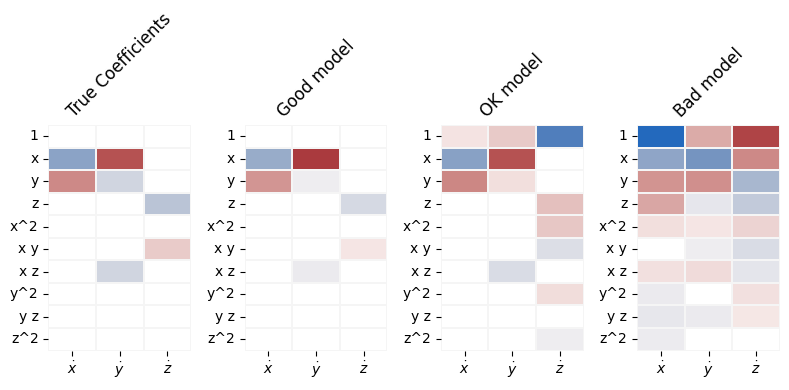

In [8]:
fig = plt.figure(figsize=[8, 4])
axes = fig.subplots(1, 4)
fig = compare_coefficient_plots(
    good_model.optimizer.coef_,
    lorenz_coef,
    input_features=["x", "y", "z"],
    feature_names=good_model.get_feature_names(),
    axs=axes[:2],
)
axes[1].set_title("Good model")
fig = compare_coefficient_plots(
    ok_model.optimizer.coef_,
    lorenz_coef,
    input_features=["x", "y", "z"],
    feature_names=ok_model.get_feature_names(),
    axs=[axes[0], axes[2]],
)
axes[2].set_title("OK model")
fig = compare_coefficient_plots(
    bad_model.optimizer.coef_,
    lorenz_coef,
    input_features=["x", "y", "z"],
    feature_names=bad_model.get_feature_names(),
    axs=[axes[0], axes[3]],
)
axes[3].set_title("Bad model")
plt.tight_layout()

Not all coefficients are equivalent, however.
E.g. a small coefficient in front of an $x^5$ term may mean more to you and your
use case than a larger constant coefficient.
There are different ways of evaluating how important each feature is,
but they all end up as weights in a call to a scoring metric.
In this example, weights are calculated as root mean square values of each feature.

In [9]:
weights = np.sqrt(np.sum(good_model.feature_library.transform(x) ** 2, axis=0) / len(x))
print(
    "weights are ", {feat: f"{weight:.0f}" for feat, weight in zip(features, weights)}
)

good_weighted_mse = mean_squared_error(
    lorenz_coef.T, good_model.optimizer.coef_.T, sample_weight=weights
)
good_weighted_mae = mean_absolute_error(
    lorenz_coef.T, good_model.optimizer.coef_.T, sample_weight=weights
)
print(f"Good model weighted MSE: {good_weighted_mse}")
print(f"Good model weighted MAE: {good_weighted_mae}")
ok_weighted_mse = mean_squared_error(
    lorenz_coef.T, ok_model.optimizer.coef_.T, sample_weight=weights
)
ok_weighted_mae = mean_absolute_error(
    lorenz_coef.T, ok_model.optimizer.coef_.T, sample_weight=weights
)
print(f"Ok model weighted MSE: {ok_weighted_mse}")
print(f"Ok model weighted MAE: {ok_weighted_mae}")
bad_weighted_mse = mean_squared_error(
    lorenz_coef.T, bad_model.optimizer.coef_.T, sample_weight=weights
)
bad_weighted_mae = mean_absolute_error(
    lorenz_coef.T, bad_model.optimizer.coef_.T, sample_weight=weights
)
print(f"Bad model weighted MSE: {bad_weighted_mse}")
print(f"Bad model weighted MAE: {bad_weighted_mae}")

weights are  {'1': '1', 'x': '8', 'y': '9', 'z': '25', 'x^2': '99', 'x y': '108', 'x z': '254', 'y^2': '141', 'y z': '240', 'z^2': '780'}
Good model weighted MSE: 0.0016015835534634079
Good model weighted MAE: 0.004033076589077881
Ok model weighted MSE: 0.3905081807942378
Ok model weighted MAE: 0.15888141106149473
Bad model weighted MSE: 4.302320417545709
Bad model weighted MAE: 0.3698774448459932


There are other ways of evaluating model coefficients beyond these metrics,
the most popular being ways of mathematically analyzing the stability of the discovered model.
These are beyond the scope of the tutorial, but look at the notebooks on `StabilizedLinearSR3`
and `TrappingSR3`.

## Prediction



Sometimes, there's no simple way to evaluate the functional form of the discovered model.
Some use cases, such as model predictive control, care about immediate prediction
but not the analytic differences between functions.
In these cases, it makes the most sense to evaluate the predictive capability.

A great example is the nonlinear pendulum.
If a pendulum is swinging close to origin, $f(x)=x$ and $f(x)=\sin(x)$
are very close together.
Even though coefficient metrics would say that these are different functions,
they yield very similar predictions, as shown below:

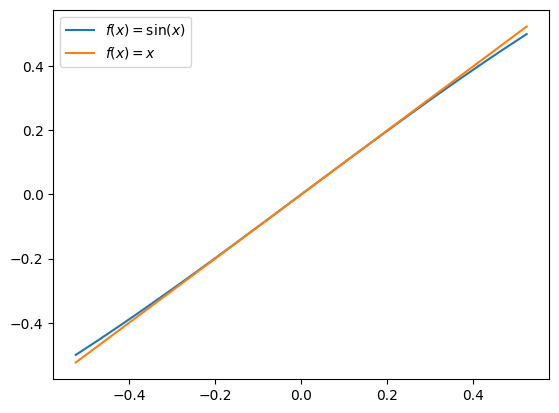

In [10]:
# +/- 30 degrees from bottom dead center
pendulum_angles = np.pi / 180 * np.linspace(-30, 30, 21)
plt.plot(pendulum_angles, np.sin(pendulum_angles), label=r"$f(x)=\sin(x)$")
plt.plot(pendulum_angles, pendulum_angles, label=r"$f(x)=x$")
plt.legend()

This occurs because the features are nearly collinear.
Understanding and compensating for collinearity of features in the function library
is a challenge.  We can avoid that difficulty if we just score models based upon prediction.

Fortunately, `model.score` depends upon `model.predict()`, which makes evaluating models
based upon prediction more straightforwards than evaluating the coefficients of the discovered
model.

In [11]:
good_model.score(x, t)

0.9997550878709895

We can inspect the predicted vs observed phase space and gradient plots for visual equivalence
as well as look for systemic bias in prediction

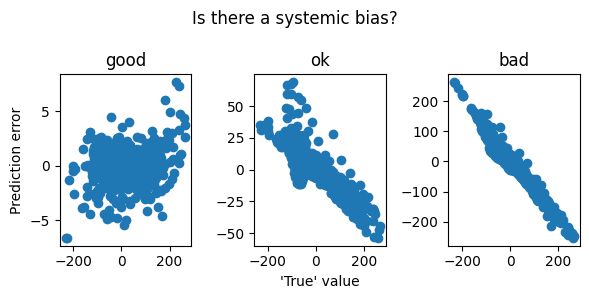

In [12]:
fig = plt.figure(figsize=[6, 3])
axes = fig.subplots(1, 3)
for ax, model, name in zip(
    axes, (good_model, ok_model, bad_model), ("good", "ok", "bad")
):
    x_dot_pred = model.predict(x)
    x_dot_true = model.differentiation_method(x, t[1] - t[0])
    ax.scatter(x_dot_true, x_dot_pred - x_dot_true)
    ax.set_title(name)
fig.suptitle("Is there a systemic bias?")
axes[1].set_xlabel("'True' value")
axes[0].set_ylabel("Prediction error")
fig.tight_layout()

**WARNING!**  All of the predictive measurements compare predictions with an
ostensibly 'true' $\dot x$, which is typically not available.
All these examples use the x_dot calculated in the first step of SINDy as "true".
Even `score()` does so internally.
If using a differentiation method that oversmooths (in the limit, to a constant line),
models that predict smaller values of $\dot x$ (in the limit, $\dot x=0$)
will score the best.

## Simulation

If we want to understand the behavior of a system over time, there's no substitute for simulation.
However, nolinear models of the type of SINDy are not guaranteed to have trajectories
beyond a certain duration.
Attempts to simulate near or beyond that duration may bog down or fail the solver.
Here's an example of a system that explodes in finite time, and cannot be simulated
beyond it: $$ \dot x = x^2 $$

There is no straightforwards way to guarantee
that a system will not blow up or go off to infinity,
but a good prediction or coefficient score is a decent indication.

In [13]:
x_sim_good = good_model.simulate(x[0], t)
x_sim_ok = ok_model.simulate(x[0], t)

The bad model becomes stiff, potentially blowing up.
A stiffer solver may be able to integrate in cases where blow-up occurs,
but these cases require individual attention and are beyond the scope of this
tutorial.  Run the following cell to see the kinds of warnings that occur,
but you will likely have to interrupt the kernel.

In [14]:
# x_sim_bad = bad_model.simulate(x[0], t)

The second problem with simulation is that the simulated dynamics may capture some essential
aspect of the problem, but the numerical difference suggests a poor model.
This simultaneous correctness and incorrectness can occur if the model recreates the
exact period and shape of an oscillation, but is out of phase
(e.g. confusing the predator and prey in lotka volterra).
It can also occur in chaotic systems, which may mirror the true system very well for a time
but must eventually diverge dramatically.  Our model and true Lorenz system are chaotic:


Text(0.5, 0.98, 'Even an accurate model of a chaotic system will look bad in time')

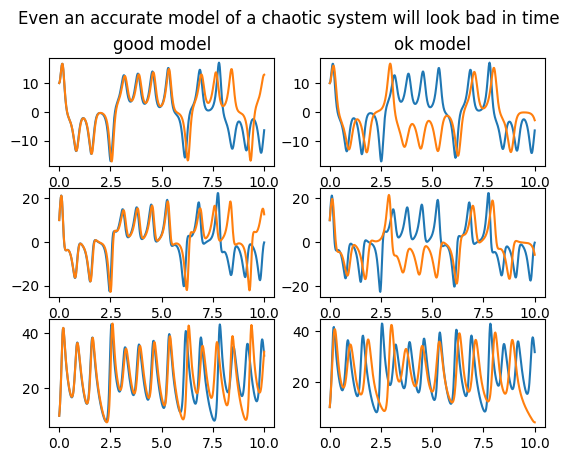

In [15]:
fig, axs = plt.subplots(3, 2)
for col, (x_sim, name) in enumerate(zip((x_sim_good, x_sim_ok), ("good", "ok"))):
    axs[0, col].set_title(f"{name} model")
    for coord_ind in range(3):
        axs[coord_ind, col].plot(t, x[:, coord_ind])
        axs[coord_ind, col].plot(t, x_sim[:, coord_ind])
fig.suptitle("Even an accurate model of a chaotic system will look bad in time")

However, chaotic systems have a useful property.
Their aperiodic trajectories sweep out a probability distribution.
And though this distribution is complex and potentially low-or-fractal-dimensional,
we can estimate a distribution from the data and see how much the simulation diverges from
that distribution.
The log likelihood measures divergence in nats, a continuous quantity from information theory.

Here, create the reference distribution from a Gaussian KDE of the true data:

In [16]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel="gaussian").fit(x)
base_likelihood = kde.score_samples(x).sum()

In [17]:
good_excess_loss = base_likelihood - kde.score_samples(x_sim_good).sum()
ok_excess_loss = base_likelihood - kde.score_samples(x_sim_ok).sum()
print(f"Our best model loses {good_excess_loss} nats of information")
print(f"Our ok model loses {ok_excess_loss} nats of information")

Our best model loses 67.98566229194694 nats of information
Our ok model loses 246.40287536631286 nats of information


## What to do with this information

These methods all help you evaluate whether a model is fitting well,
and given several models, help you evaluate the best for a given application.
If a model is performing poorly, it may be possible to construct a better SINDy model.
The next tutorial describes how to choose better components for the SINDy model.